# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

In [15]:
# Exercise 1
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import statsmodels.api as sm
from scipy.stats import binom

Exercise 2 


In [16]:
NOW = pd.read_csv("NOW_database.txt",sep=",")
print(len(NOW))

85679


Exercise 3

a) Remove all rows where LAT = LONG = 0; these occurrences have incorrect coordinates. Drop rows where SPECIES is sp. or indet. ; these occurrences have not been properly identifed.

b) Next we will assign each occurrence to a specific Mammal Neogene (MN) time unit. Table 1 shows the time boundaries of each time unit. Assign each occurrence to a correct time unit by calculating the mean of MIN AGE and MAX AGE. If the mean age of an occurrence is precisely on the boundary between two time units, assign the occurrence to the older time unit. If the mean age of an occurrence is outside of the MN time interval, assign it to a pre-MN or post-MN category.

c) Sometimes expert knowledge may be used to override some of theinformation recorded in the data. In our case, experts in palaeontology tell us that occurrences in the localities Samos Main Bone Beds and Can Llobateres I should be assigned to time units MN12 and MN9, respectively. Check these and if necessary, edit the time units to their correct values.

d) We need to be able to identify all occurrences of each species. Assign a unique identification number for each unique combination of GENUS and SPECIES. Create a new column in the DataFrame and label each occurrence with a corresponding species identification number.

e) Each locality should contain no more than one occurrence of any species. Check whether this is the case and remove duplicate copies, if necessary.

f) How many rows are we left with in the DataFrame (compare with exercise 2)? How many unique species and localities are identified?

In [17]:
# 3a
# remove invalid rows
mask = ((NOW["LAT"]==0) & (NOW["LONG"]==0)) | (NOW["SPECIES"]=="sp.") | (NOW["SPECIES"]=="indet.")
NOW = NOW[~mask]
print(len(NOW))

63315


In [18]:
# 3b
# assign a time unit based on mean age of occurrence


MN_bounds = pd.read_csv("time_unit.txt",sep=" ")

num_bounds = [20000] + MN_bounds["max"].to_list() + [0.01,0]
num_bounds = num_bounds[::-1]
name_bounds = ["pre-MN"] + MN_bounds["name"].to_list() + ["post-MN"]
name_bounds = name_bounds[::-1]


NOW["AVG_AGE"] = (NOW["MIN_AGE"] + NOW["MAX_AGE"])/2

NOW["Time Unit"] = pd.cut(NOW["AVG_AGE"], num_bounds, labels=name_bounds, include_lowest=True, right=False)

In [19]:
# 3c

place_1 = NOW[NOW["NAME"] == "Can Llobateres I"]
place_2 = NOW[NOW["NAME"] == "Samos Main Bone Beds"]

print(f"There are {len(place_1)} occurances of Can Llobateres I")
print(f"There are {len(place_2)} occurances of Samos Main Bone Beds")

There are 0 occurances of Can Llobateres I
There are 52 occurances of Samos Main Bone Beds


In [20]:
# 3c continued 
# since Can Llobateres I does not exist, we just have to 
# replace Samos Main Bone Beds

NOW.loc[NOW["NAME"]=="Samos Main Bone Beds","Time Unit"] = "MN12"

In [21]:
# 3d
# species id number

groups = NOW.groupby(["GENUS","SPECIES"]).ngroup()
NOW["ID"] = groups + 1

In [22]:
# 3e
# drops duplicates

NOW.drop_duplicates(subset=["NAME","ID"],inplace=True)

In [23]:
# 3f
# sanity check

rows_left = len(NOW)
species = NOW["ID"].nunique()
localities = NOW["NAME"].nunique()

print(f"""There are {rows_left} rows in the dataframe. This contains
{species} species as well as {localities} localities.""")

There are 63251 rows in the dataframe. This contains
11358 species as well as 7249 localities.


Exercise 4 - Create a DataFrame that shows for each species how many occurrences it has in each time unit. Then, create a different DataFrame that shows for each species the time unit when it is first observed (i.e. the oldest time unit). For each time unit, calculate the proportion of first occurrences to all occurrences. Plot the proportion of first occurrences over time. Also, plot the total number of occurrences over time.

C:\Users\joelj\AppData\Local\Temp\ipykernel_39968\1522811183.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_per_timeunit = NOW.groupby(["ID","Time Unit"]).size()


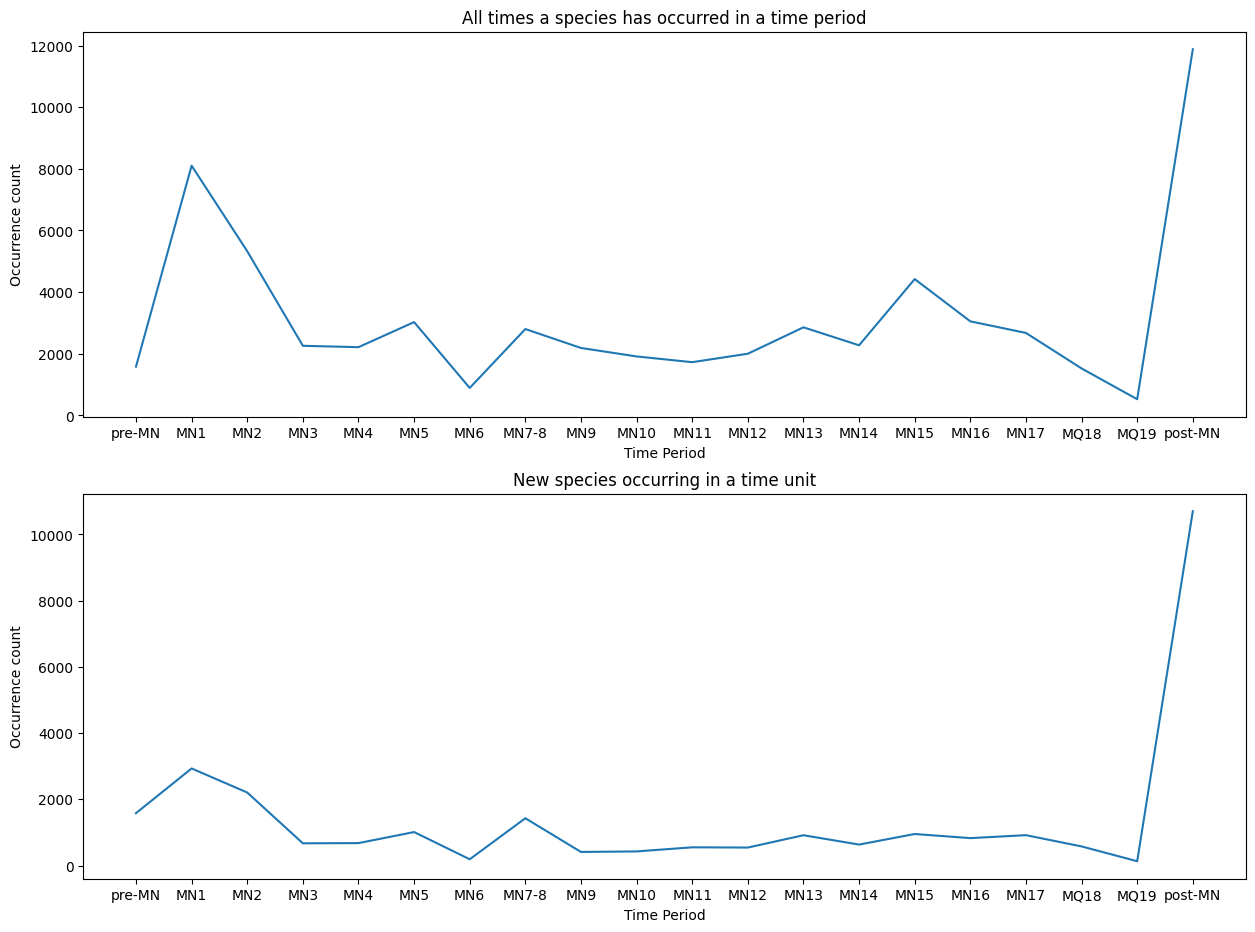

In [62]:
# 4
# calculates all occurrences and first occurrences in a certan time period

#creates dataframe with species appearances per time unit
species_per_timeunit = NOW.groupby(["ID","Time Unit"]).size()
counts = species_per_timeunit.values.reshape(-1,len(name_bounds)) #changes shape so that it fits in df with rows=species and cols=time unit

ids = species_per_timeunit.index.get_level_values("ID")[::len(name_bounds)] #slicing is needed so only rows with next species are taken
time_periods = species_per_timeunit.index.get_level_values("Time Unit")[:len(name_bounds)]

species_appearance = pd.DataFrame(counts,columns=time_periods, index=ids)
species_appearance.index.name = "ID"


# creates a dataframe with first occurrences of each species.
# Rest of the dataframe is set to zero

non_zero_pos = species_appearance.ne(0)
first_true = (non_zero_pos.cumsum(axis=1) == 1) & (non_zero_pos) #only keeps the first value as true

first_species_appearance = species_appearance.copy()
first_species_appearance[~first_true] = 0


#adds new column to original database checking if a row first occurrence or not
species_id = first_true.index.get_indexer(NOW["ID"])
species_time_unit = first_true.columns.get_indexer(NOW["Time Unit"])
NOW["First Occurrence"] = first_true.values[species_id, species_time_unit]

# sums up occurances of all species
all_occurrence = species_appearance.sum(axis=0)
# number of first occurrence in each time unit
new_occurrence = first_species_appearance.sum(axis=0)

proportion = new_occurrence/all_occurrence

# plots 
fig, ax = plt.subplots(2,1)
fig.set_figwidth(15)
fig.set_figheight(11)
ax[0].plot(name_bounds[::-1], all_occurrence)
ax[0].set_title("All times a species has occurred in a time period")
ax[0].set_xlabel("Time Period")
ax[0].set_ylabel("Occurrence count")
ax[1].plot(name_bounds[::-1], new_occurrence)
ax[1].set_title("New species occurring in a time unit")
ax[1].set_xlabel("Time Period")
ax[1].set_ylabel("Occurrence count")
plt.show()

Exercise 5 - 

a) Create a DataFrame that collects the following information for every locality: locality number (LIDNUM), longitude, latitude, time unit, number of rst occurrences in the locality, number of all occurrences in the locality and proportion of first occurrences in the locality.

b) Visualize the distribution of localities in space and time. For each time unit, plot the LAT and LONG coordinates of each locality (corresponding to the time unit). For example, you can use the above codes to create a geographic map and then use a standard matplotlib scatter plot to add the localities. Choose the marker size for each locality such that it is relative to the number of occurrences in the locality (bigger markers for bigger localities). 

c) Based on exercises 4 and 5, what kind of observations about sampling can you make? Are there differences in sampling density over space and time? Compare some basic sampling properties between Africa, Asia and Europe, e.g. spatial coverage and average number of occurrences per locality.


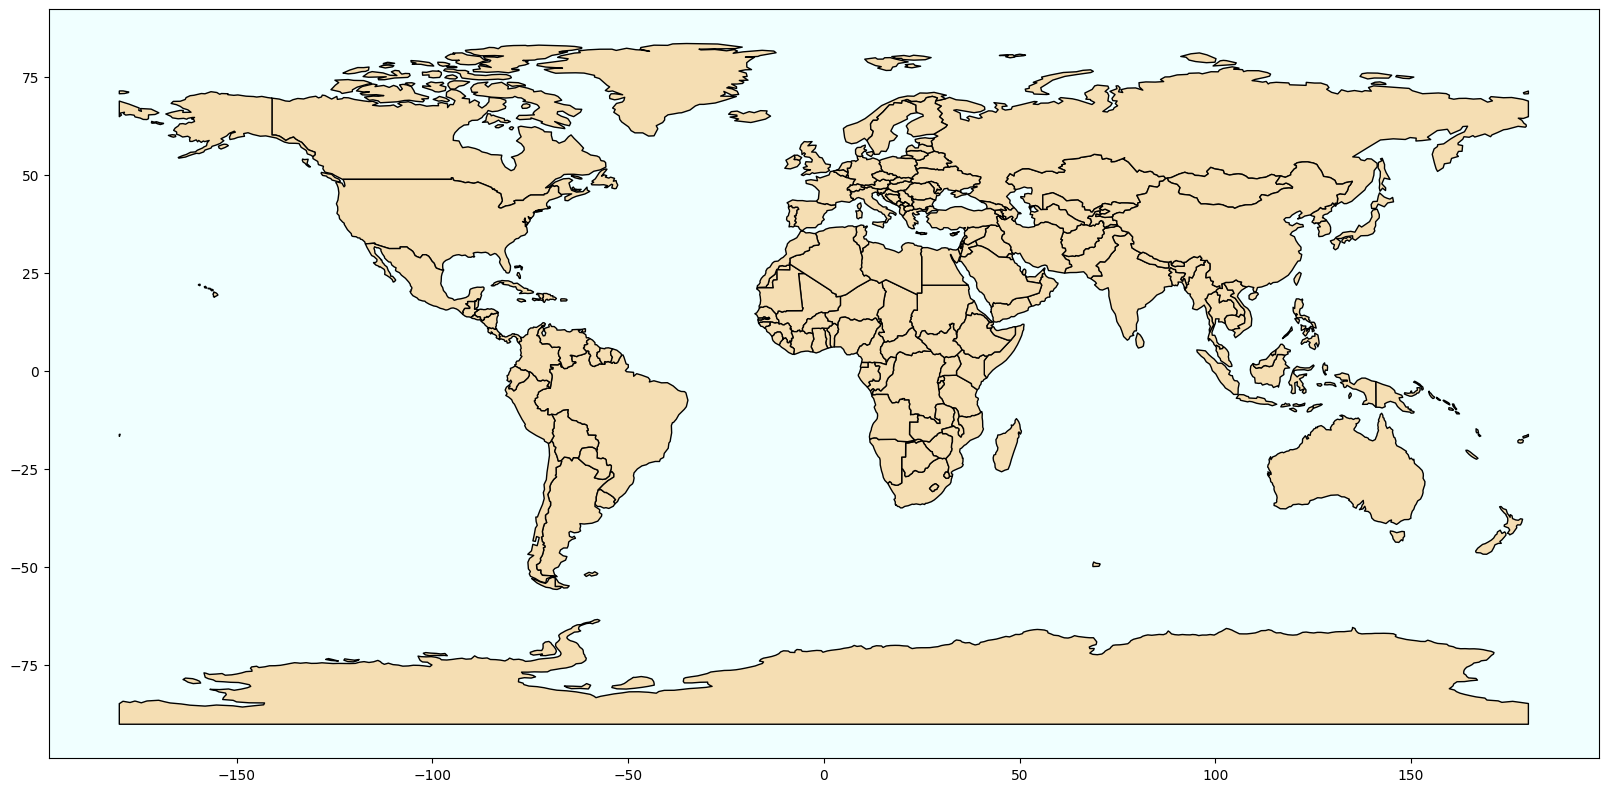

In [25]:
# part 5 setup 
# load up world map


# this has been depreciated, so the import is done differently
# world = (geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres")))


world = geopandas.read_file("NaturalEarth_lowres.zip")

fig_wld, ax_wld = plt.subplots(figsize=(20,10))
world.plot(ax=ax_wld, color="wheat", edgecolor="black")
ax_wld.set_facecolor("azure")

In [26]:
# 5a

# test = NOW.groupby(["LIDNUM","Time Unit"]).size()
# test[test.values!= 0]
# test above shows that there is only one time unit per locality (since number
# of rows is the same as if it were just groupby("LIDNUM"))


groups = NOW.groupby("LIDNUM")

locality_df = pd.DataFrame(groups[["LONG","LAT","Time Unit"]].first())

locality_df["First Occurrences"] = groups["First Occurrence"].sum()
locality_df["All Occurrences"] = groups.size()
locality_df["Proportion of First Occurrences"] = locality_df["First Occurrences"]/locality_df["All Occurrences"]

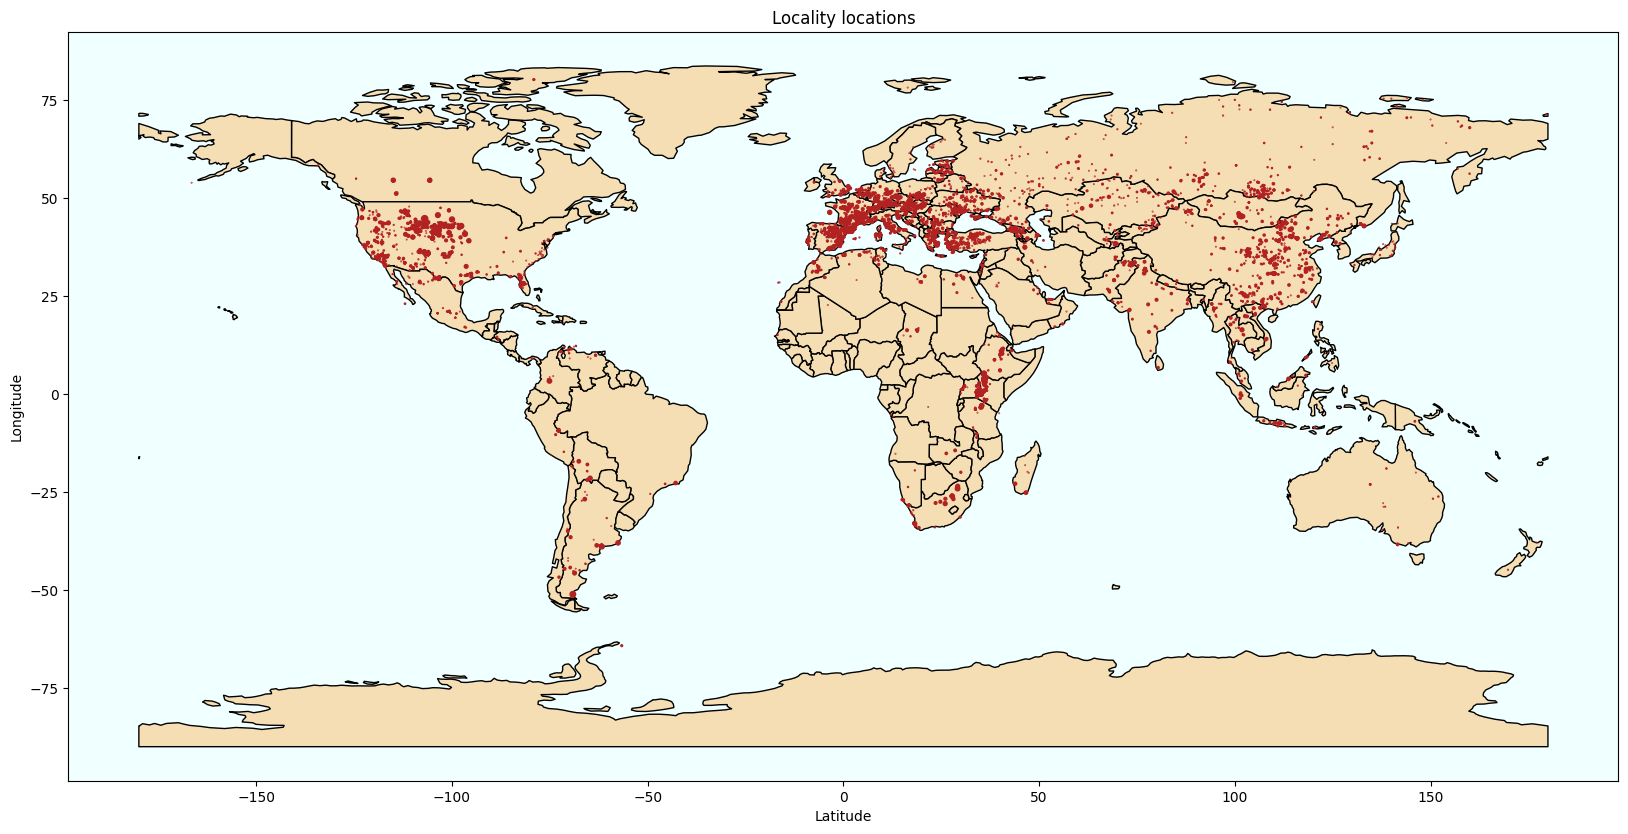

In [27]:
# 5b
# plot the values on a world map

fig_wld, ax_wld = plt.subplots(figsize=(20,10))
world.plot(ax=ax_wld, color="wheat", edgecolor="black")
ax_wld.set_facecolor("azure")

marker_scaled = 20*locality_df["All Occurrences"]/(locality_df["All Occurrences"].max())
ax_wld.scatter(locality_df["LONG"],locality_df["LAT"],s=marker_scaled,c="firebrick")
ax_wld.set_xlabel("Latitude")
ax_wld.set_ylabel("Longitude")
ax_wld.set_title("Locality locations")
plt.show()

5c

There are large differences in sampling density over space and time. As seen, the greatest number of samples come from the pre-MN era, and the least from MN1. There is a spike at MN-19. All other time periods apart from these also have some variation in sample density between them.

Additionally, in terms of geography, the largest number of samples by far are collected in Europe. North America has some localities that have relatively large number of samples taken from them, but not a lot of different localities. Asia has more localities, but with each locality containing not too many samples.

Exercise 6 - For each locality, look at a ten by ten degrees area (in latitude and longitude) centered around the locality. Record the total number of occurrences and total number of rst occurrences found within that square in the time unit corresponding to the focal locality. Also, record the total number of occurrences within that square in the preceding time unit (relative to the focal locality). Record these numbers into the DataFrame that was created in exercise 5 (add new columns).

In [28]:
#6
# Additional information on localities

def surroundings(locality):
    """Provides data on first/all occurrences near the locality in question, over the current and previous time unit"""
    mask_lat = (locality_df["LAT"] >= (locality["LAT"] - 5)) & (locality_df["LAT"] <= (locality["LAT"] + 5))
    mask_long = (locality_df["LONG"] >= (locality["LONG"] - 5)) & (locality_df["LONG"] <= (locality["LONG"] + 5))
    mask_current_time = locality_df["Time Unit"] == locality["Time Unit"]
    # try else used to make sure earliest time period does not throw an error
    try:
        previous_time_unit = name_bounds[1+name_bounds.index(locality["Time Unit"])]
    except:
        previous_time_unit = None
    mask_previous_time = locality_df["Time Unit"] == previous_time_unit
    __surroundings_current = locality_df[mask_lat & mask_long & mask_current_time]
    __surroundings_past = locality_df[mask_lat & mask_long & mask_previous_time]


    return pd.Series({
        "All surrounding occurrences, same time": __surroundings_current["All Occurrences"].sum(),
        "First surrounding occurrences, same time": __surroundings_current["First Occurrences"].sum(),
        "All surrounding occurrences, previous time unit": __surroundings_past["All Occurrences"].sum(),
        "First surrounding occurrences, previous time unit": __surroundings_past["First Occurrences"].sum()
    })

# initialize
locality_df["All surrounding occurrences, same time"] = 0
locality_df["First surrounding occurrences, same time"] = 0
locality_df["All surrounding occurrences, previous time unit"] = 0
locality_df["First surrounding occurrences, previous time unit"] = 0

locality_df[[
        "All surrounding occurrences, same time",
        "First surrounding occurrences, same time",
        "All surrounding occurrences, previous time unit",
        "First surrounding occurrences, previous time unit"
    ]] = locality_df.apply(surroundings, axis=1)

locality_df

,LONG,LAT,Time Unit,First Occurrences,All Occurrences,Proportion of First Occurrences,"All surrounding occurrences, same time","First surrounding occurrences, same time","All surrounding occurrences, previous time unit","First surrounding occurrences, previous time unit"
LIDNUM,,,,,,,,,,
10001,-99.133333,19.433330,MN2,1,1,1.000000,1,1,0,0
10002,-96.414167,16.898056,MN3,2,3,0.666667,7,4,1,1
10003,-96.716667,17.050000,MN5,1,1,1.000000,9,3,0,0
10004,-96.716667,17.050000,MN5,2,8,0.250000,9,3,0,0
10005,-96.716667,17.050000,MN6,0,1,0.000000,1,0,9,3
...,...,...,...,...,...,...,...,...,...,...
29865,35.907392,0.860179,MN13,0,1,0.000000,208,60,0,0
29866,99.168854,9.135719,pre-MN,1,1,1.000000,23,23,0,0
29870,114.668056,40.234167,MQ18,3,4,0.750000,141,61,173,26


Exercise 7

a) Create the regression data set. Only use localities within the co-ordinates-25<LONG<40 and LAT>35 and time unit within MN2 MQ19 (why not include MN1?). Create an m 2 array, where m is the total number of occurrences in all the localities. Each row in the array represents one occurrence. For each occurrence, fill in to the rst column of the array the number of occurrences in the focal area in the previous time unit (calculated in exercise 6). For the second column, fill in 1 for a first occurrence and 0 for other occurrences. 

b) Perform logistic regression. 

c) Plot regression curve and 95%-condence intervals.

In [52]:
# 7a
# data on Europe

mask_location = (locality_df["LONG"] > -25) & (locality_df["LONG"] < 40) & (locality_df["LAT"] > 35)
mask_time = (locality_df["Time Unit"] <= "MN2") & (locality_df["Time Unit"] >= "MQ19")


NOW_europe = locality_df[mask_location & mask_time]
NOW_europe["Not First Occurrences"] = NOW_europe["All Occurrences"] - NOW_europe["First Occurrences"]


# first goes through the ones and creates both arrays, then creates the arrays for zeros
X_1 = np.repeat(NOW_europe["All surrounding occurrences, previous time unit"].values, NOW_europe["First Occurrences"].values)
y_1 = np.ones(X_1.shape[0])

X_0 = np.repeat(NOW_europe["All surrounding occurrences, previous time unit"].values, NOW_europe["Not First Occurrences"].values)
y_0 = np.zeros(X_0.shape[0])

X = np.concatenate((X_1, X_0))
y = np.concatenate((y_1, y_0))

data = np.vstack((X,y))

C:\Users\joelj\AppData\Local\Temp\ipykernel_39968\3678655270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NOW_europe["Not First Occurrences"] = NOW_europe["All Occurrences"] - NOW_europe["First Occurrences"]


Optimization terminated successfully.
         Current function value: 0.556376
         Iterations 5
The 95% confidence intervals are [[-8.58597941e-01 -7.75353526e-01]
 [-8.51813770e-04 -6.73524994e-04]]


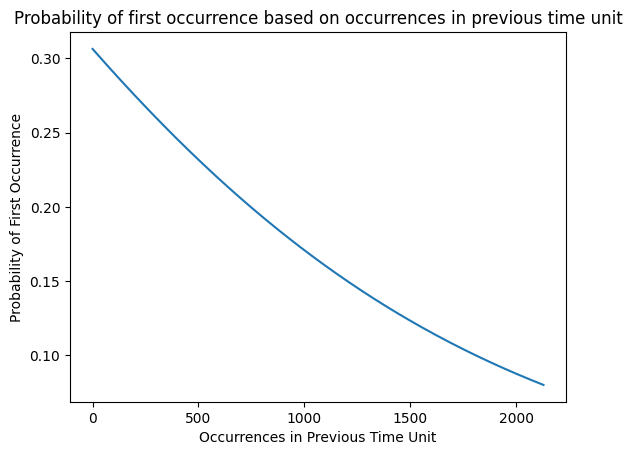

In [53]:
# 7b & c

def logistic(x, consts):
    return 1.0 / (1.0 + np.exp(-(consts[0] + consts[1]*x)))

X_k = sm.add_constant(X)

model = sm.Logit(y,X_k)
result = model.fit()

coef = result.params
plt.title("Probability of first occurrence based on occurrences in previous time unit")
plt.xlabel("Occurrences in Previous Time Unit")
plt.ylabel("Probability of First Occurrence")
X_coord = np.linspace(X_k.min(),X_k.max(),300)


plt.plot(X_coord, logistic(X_coord, coef))

conf95 = result.conf_int(alpha=0.05)
print(f"The 95% confidence intervals are {conf95}")

Exercise 8

For each European locality, calculate the expected proportion of first occurrences in the focal area surrounding the locality using the logistic regression calculated in exercise 7.

Exercise 9

For each European locality, calculate the probability of observing as many or more first occurrences in the focal area than what is actually found. Assume that occurrences are binomially distributed to first occurrences and not first occurrences , so that the probability of a given occurrence to be a first occurrence is equal to the expected pro portion of first occurrences in the focal area. You may use, for example, the scipy.stats.binom library (https://docs.scipy.org/doc/scipy-0.14.0/ reference/generated/scipy.stats.binom.html) for the calculations

In [54]:
# 8
# predict first occurrences in focal area and checks if it is an outlier

NOW_europe["Expected First Occurrences, Probability"] = logistic(NOW_europe["All surrounding occurrences, previous time unit"],coef)


# 9
n = NOW_europe["All Occurrences"]
k = NOW_europe["First Occurrences"]
p = NOW_europe["Expected First Occurrences, Probability"]


NOW_europe["Prob of more first occurrences"] = binom.sf(k,n,p)
NOW_europe["Prob of more first occurrences"]

C:\Users\joelj\AppData\Local\Temp\ipykernel_39968\2485152509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NOW_europe["Expected First Occurrences, Probability"] = logistic(NOW_europe["All surrounding occurrences, previous time unit"],coef)
C:\Users\joelj\AppData\Local\Temp\ipykernel_39968\2485152509.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NOW_europe["Prob of more first occurrences"] = binom.sf(k,n,p)


LIDNUM
20001    0.015860
20002    0.668170
20003    0.095847
20004    0.000005
20005    0.462183
           ...   
29769    0.000000
29770    0.000000
29772    0.577976
29846    0.304626
29847    0.063117
Name: Prob of more first occurrences, Length: 3128, dtype: float64

Exercise 10 - For each time unit, plot localities on a map covering the coordinates defined in exercise 7a and indicate their significance level with a sliding color scheme. Highlight localities that have p-value less than 0.05 (i.e. probability of observations is less than 0.05). Describe briefly the overall patterns that you observe.

C:\Users\joelj\AppData\Local\Temp\ipykernel_39968\941603994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NOW_europe["Significance"] = "lightsalmon"


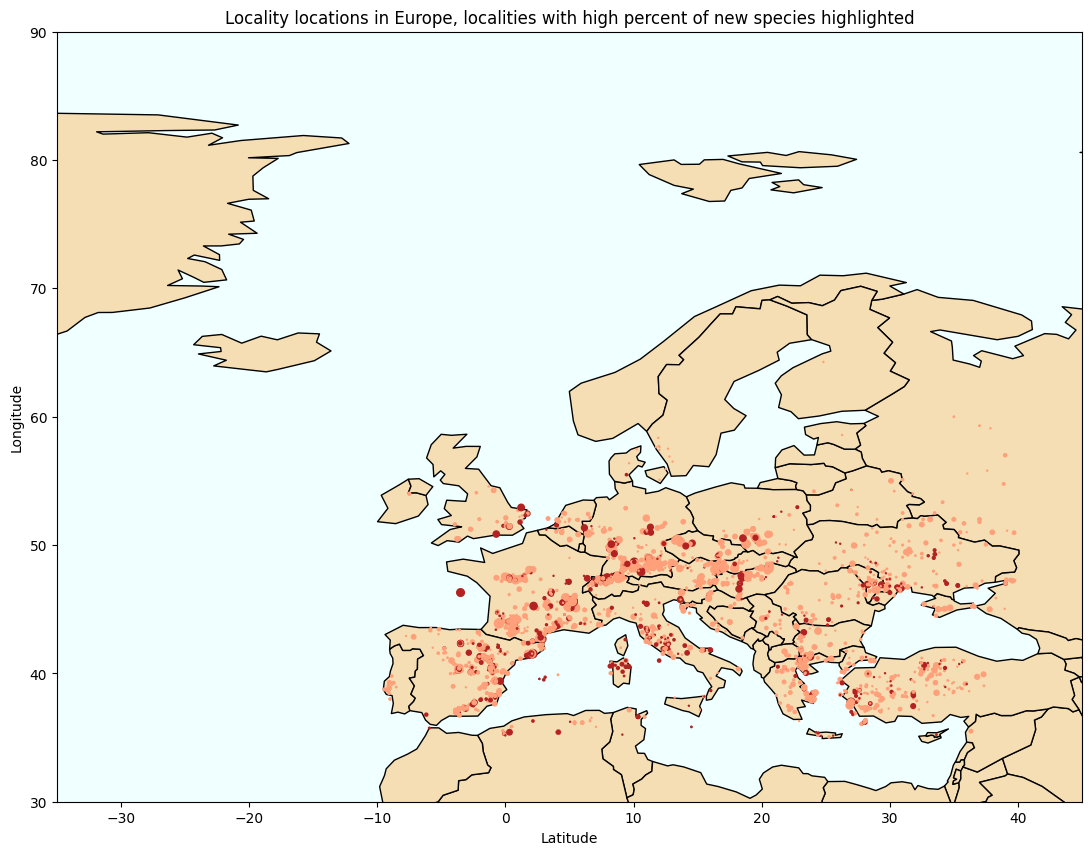

In [ ]:
# 9
# plots this on the world map, with outliers marked differently

fig_wld, ax_wld = plt.subplots(figsize=(20,10))
world.plot(ax=ax_wld, color="wheat", edgecolor="black")
ax_wld.set_facecolor("azure")

NOW_europe["Significance"] = "lightsalmon"
NOW_europe.loc[NOW_europe["Prob of more first occurrences"] < 0.05,"Significance"] = "firebrick"

marker_scaled = 50*NOW_europe["All Occurrences"]/(NOW_europe["All Occurrences"].max())
ax_wld.scatter(NOW_europe["LONG"],NOW_europe["LAT"],s=marker_scaled,c=NOW_europe["Significance"])

ax_wld.set_xlim(-35, 45) 
ax_wld.set_ylim(30, 90) 

ax_wld.set_xlabel("Latitude")
ax_wld.set_ylabel("Longitude")
ax_wld.set_title("Locality locations in Europe, localities with high percent of new species highlighted in red")

plt.show()

There is high density of sites in central europe, and this is also where the most outliers lie. Regions such as Ukraine and the UK have almost no outliers, whereas Spain and France are two countries with a large proportion of outliers. Additionally, the outliers are of different sizes - there are both large and small localities being marked as outliers.